# Imports

In [1]:
# Essential Libraries
import os
import pandas as pd
import numpy as np
import re, string, unicodedata

#Tesseract and Pillow Library
import pytesseract
from PIL import Image

#Gensim Library for Text Processing
import gensim.parsing.preprocessing as gsp
from gensim import utils

#Sentiment Analysis (Positive or Negative)
from textblob import TextBlob, Word
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_scorer = SentimentIntensityAnalyzer()

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Warning Handler
import warnings
warnings.filterwarnings("ignore")

#Garbage Collection
import gc

## Config

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../../Config.ini");

## Tesseract.exe

In [3]:
pytesseract.pytesseract.tesseract_cmd = config["PATH"]["pytesseract"]

## Why PyTesseract?

- Python-tesseract is a wrapper for <u>**Google’s Tesseract-OCR Engine**</u>. It is also useful as a stand-alone invocation script to tesseract, as it can read all image types supported by the Pillow and Leptonica imaging libraries, including jpeg, png, gif, bmp, tiff, and others. Additionally, if used as a script, Python-tesseract will print the recognized text instead of writing it to a file.

NOTE:
- When using, make sure to <u>install</u> its [**dependency**](https://github.com/UB-Mannheim/tesseract/wiki), <u>**add it to your environment variables**</u> and

# Images

## Paths

In [4]:
sample_images = config["PATH"]["Data"] + "Sample Data Files/"
test_images = config["PATH"]["Data"] +  "Dataset/"

### Count of Images found in Sample folder

In [5]:
len([v for v in os.listdir(sample_images) if v.split(".")[1] in ["jpg", "jpeg", "png", "gif", "bmp", "tiff"]])

3

### Count of Images found in Dataset folder

In [6]:
len([v for v in os.listdir(test_images) if v.split(".")[1] in ["jpg", "jpeg", "png", "gif", "bmp", "tiff"]])

239

# Creating the Function
- Create a function that accepts Directory
- From the directory, scan the files and puts it in a list
- From the list, run the tesseract to read the text

In [7]:
def ExtractText(directory):
    """
    Accepts a directory to scan and read to gather all the images

    Returns the following in DataFrame format:
    file: Filename
    text: Text_Extracted
    """

    extracted_txt = []   #list to store the extracted text
    
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            
            if file.split(".")[1] in ["jpg", "jpeg", "png", "gif", "bmp", "tiff"]: # make sure to all images
                filepath = subdir + os.sep + file
                #get_osd = pytesseract.image_to_osd(filepath, output_type="dict", config="--psm 0 -c min_characters_to_try=1") # get orientation and language detected

                get_image = Image.open(filepath) # fetch file

                #get_rotation = 360 - get_osd["rotate"]
                #get_image = get_image.rotate(get_rotation) # make sure it is properly rotated
                
                text = pytesseract.image_to_string(get_image, timeout=30) # get text from image
                
                if not text:
                    extracted_txt.extend([[file, np.nan]]) # Returns blank if nothing was read
                else:   
                    extracted_txt.extend([[file, text]])
                
    folder_name = os.path.split(os.path.dirname(subdir))[-1]
    print(f"Text Extracted from the files in '{folder_name}' folder. \nTotal image found: {len(extracted_txt)}")

    return pd.DataFrame(extracted_txt, columns=["Filename", "Text_Extracted"])

# Using Sample Image Folder

## Applying the ExtractText Function to Sample Images

In [8]:
DF_SAMPLE = ExtractText(sample_images)
DF_SAMPLE

Text Extracted from the files in 'Sample Data Files' folder. 
Total image found: 3


,Filename,Text_Extracted
0,Sample_Negative.jpg,Of course gay men\n\ndress well. They didn't\n...
1,Sample_Positive.jpg,NaN
2,Sample_Random.jpg,NaN


In [9]:
pytesseract.image_to_osd(sample_images+DF_SAMPLE["Filename"][0],output_type='dict')

{'page_num': 0,
 'orientation': 0,
 'rotate': 0,
 'orientation_conf': 0.91,
 'script': 'Latin',
 'script_conf': 20.0}

## Image Display (From Testing)

### Sample_Negative.jpg

Text:
Of course gay men

dress well. They didn't
spend all that time in
the closet doing nothing.

ee Being Gay & Proud Quotes
www. geckoandfly.com




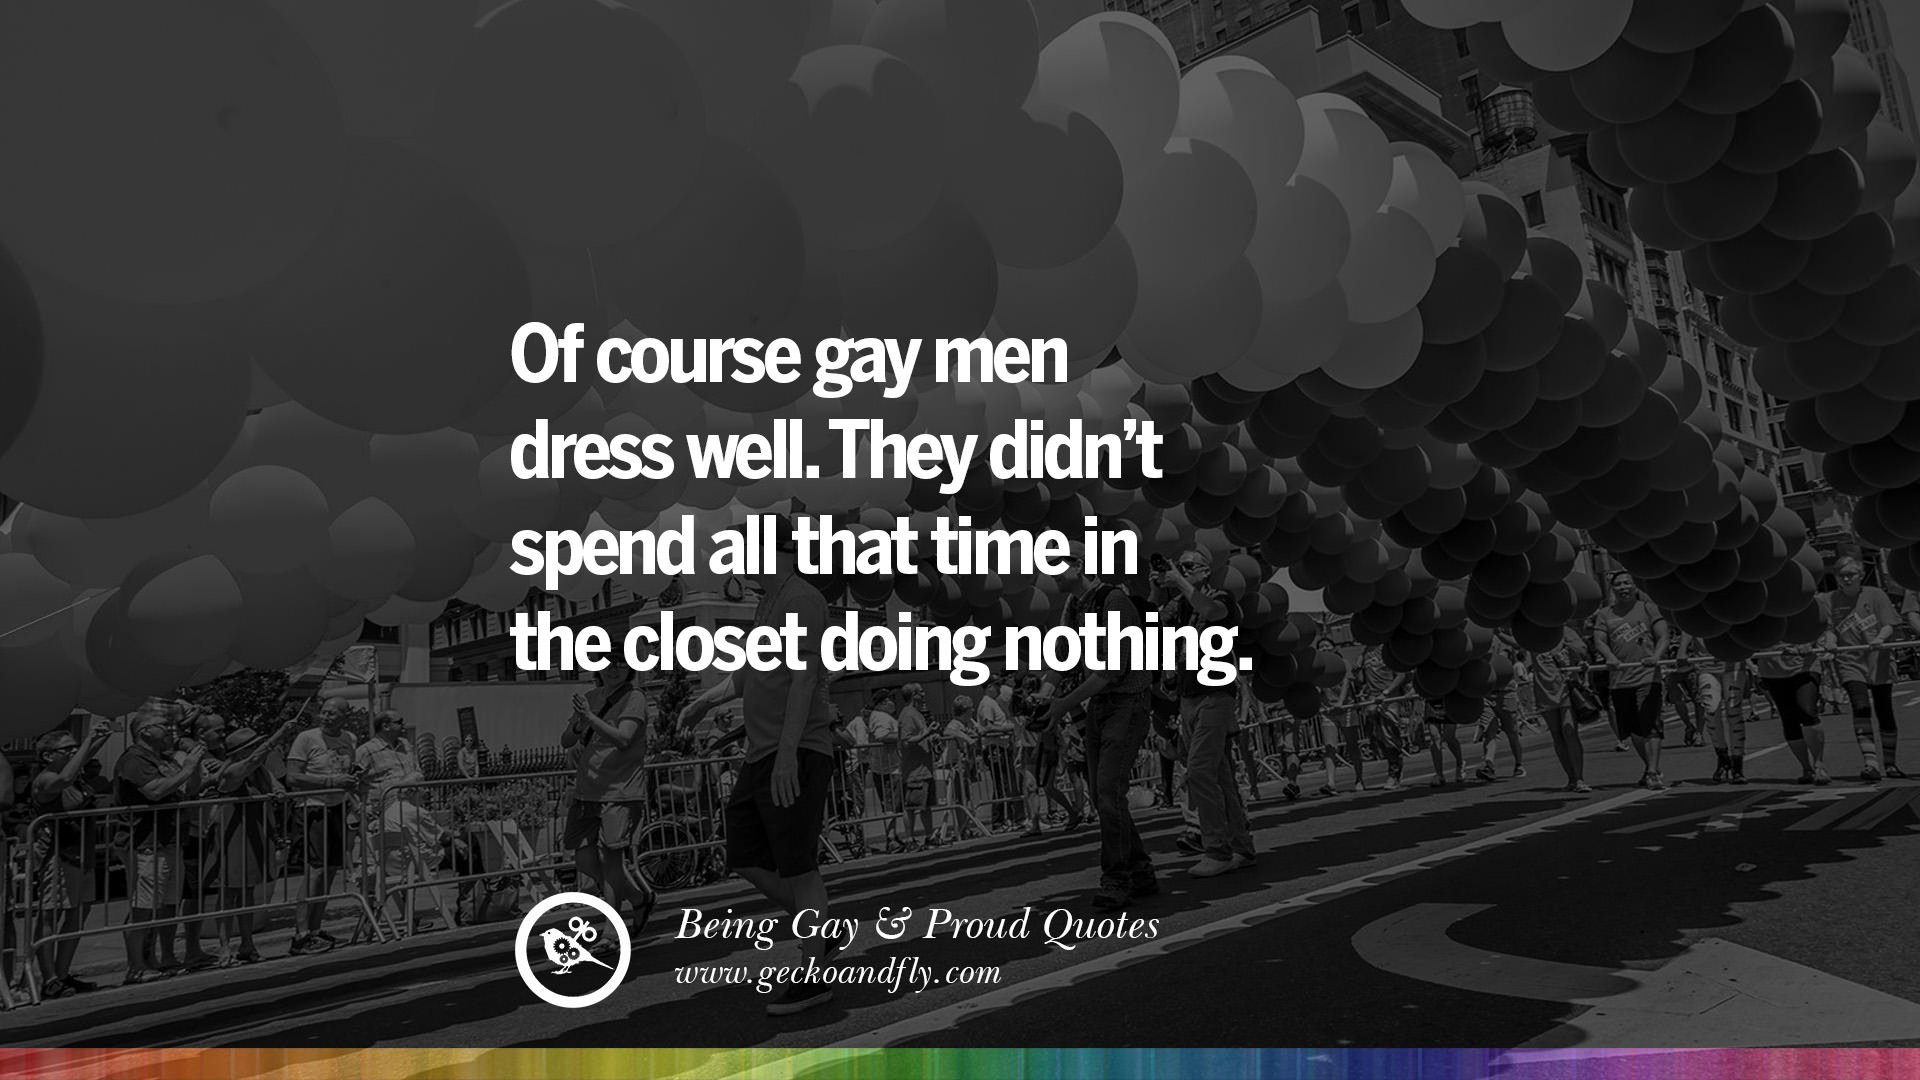

In [10]:
print(f"Text:\n{DF_SAMPLE["Text_Extracted"][0]}")
Image.open(sample_images+DF_SAMPLE["Filename"][0])

### Sample_Positive.jpg

Text:
nan


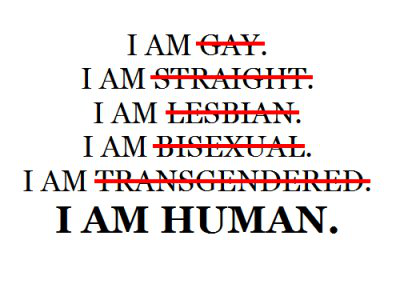

In [11]:
print(f"Text:\n{DF_SAMPLE["Text_Extracted"][1]}")
Image.open(sample_images+DF_SAMPLE["Filename"][1])

### Sample_Random.jpg

Text:
nan


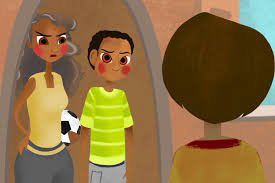

In [12]:
print(f"Text:\n{DF_SAMPLE["Text_Extracted"][2]}")
Image.open(sample_images+DF_SAMPLE["Filename"][2])

## Takeaways
- The model can be a bit tough with identifying things and tends to look hallucinate in terms of misrepresenting the characters

# Using the Test Image Folder

In [13]:
DF_TEST = ExtractText(test_images)
DF_TEST

Text Extracted from the files in 'Dataset' folder. 
Total image found: 239


,Filename,Text_Extracted
0,Test100.jpg,NaN
1,Test1001.jpg,"When people ask\nwhat I see in you,\nI just sm..."
2,Test1012.jpg,LOVE\n\n1S TOO BEA!\nTO BE HI\nIN THE CL\n
3,Test1022.jpg,LOVE\n®\n
4,Test103.jpg,NaN
...,...,...
234,Test945.jpg,HATE\nIr Has causED ALOT *\nOF PROBLEMS IN THI...
235,Test946.jpg,"“Lam not free\nwhile any woman\nis unfree, eve..."
236,Test957.jpg,"I THINK Wik GAY ISA me,\nAND ITS SOMETHING\n\n"
237,Test979.jpg,NaN


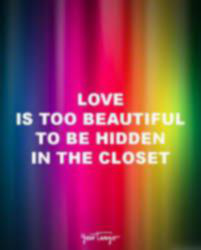

In [14]:
Image.open(test_images+DF_TEST["Filename"][2])

## Text Cleaning Functions

### Removing Contractions

In [15]:
def decontractor(sentence):
    """
    Expanding contractions
    """

    if type(sentence) != str:
        return sentence

    else:
        sentence = re.sub(r"n\'t", " not", sentence)
        sentence = re.sub(r"\'re", " are", sentence)
        sentence = re.sub(r"\'s", " is", sentence)
        sentence = re.sub(r"\'d", " would", sentence)
        sentence = re.sub(r"\'ll", " will", sentence)
        sentence = re.sub(r"\'t", " not", sentence)
        sentence = re.sub(r"\'ve", " have", sentence)
        sentence = re.sub(r"\'m", " am", sentence)
        return sentence

### General Cleaning

In [16]:
def clean_text(text):
    """
    remove punctuation and special characters
    lower case all the text as well
    """

    if type(text) != str:
        return text
        
    else:

        text = text.replace("\n", " ")
        
        # Create a translation table to 
        # !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r\x0b\x0c
        translator = str.maketrans('', '', string.punctuation + string.printable.replace(' ','')[62:])
        text = text.translate(translator)
        
        #clean_text = re.sub(r'[^\w\s]', '', text) # Alternative route using re
        #text = re.sub(r'http\S+', '', text)
    
        # Remove leading and trailing whitespace
        text = text.strip()
        text = text.lower()
    
        return text

In [17]:
DF_TEST["Text_Extracted"] = DF_TEST["Text_Extracted"].apply(lambda x: clean_text(decontractor(x)))

In [18]:
DF_TEST.head()

,Filename,Text_Extracted
0,Test100.jpg,NaN
1,Test1001.jpg,when people ask what i see in you i just smile...
2,Test1012.jpg,love 1s too bea to be hi in the cl
3,Test1022.jpg,love ®
4,Test103.jpg,NaN


In [19]:
def TB_sentiment_tag(text):

    if type(text) != str:
        return np.nan
    
    TB_tag = TextBlob(text).sentiment.polarity
    
    # decide sentiment as positive, negative and neutral 
    if TB_tag >= 0.00 : 
        return "Positive"   
    elif TB_tag <= 0.00 : 
        return "Negative" 
    else:
        return "Neutral"

In [20]:
def NLTK_sentiment_tag(text):

    if type(text) != str:
        return np.nan
    
    NLTK_tag = TextBlob(text).sentiment.polarity
    
    # decide sentiment as positive, negative and neutral 
    if NLTK_tag >= 0.00 : 
        return "Positive"   
    elif NLTK_tag <= 0.00 : 
        return "Negative" 
    else:
        return "Neutral"

In [21]:
DF_TEST["TextBlob_Sentiment"] = DF_TEST["Text_Extracted"].apply(lambda x: TB_sentiment_tag(x))
DF_TEST["NLTK_Sentiment"] = DF_TEST["Text_Extracted"].apply(lambda x: NLTK_sentiment_tag(x))

### Checking if there's any difference

In [22]:
DF_TEST_NONULL = DF_TEST[~DF_TEST["Text_Extracted"].isnull()].copy().reset_index(drop=True)

In [23]:
(DF_TEST_NONULL["TextBlob_Sentiment"] != DF_TEST_NONULL["NLTK_Sentiment"]).sum()

0

In [24]:
DF_TEST["TextBlob_Sentiment"].value_counts()

TextBlob_Sentiment
Positive    107
Negative     13
Name: count, dtype: int64

In [25]:
DF_TEST["NLTK_Sentiment"].value_counts()

NLTK_Sentiment
Positive    107
Negative     13
Name: count, dtype: int64

# Free up memory

In [26]:
gc.collect()

203